# Load and demonstration of CIFAR-10 dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'r') as f:
    datadict = pickle.load(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

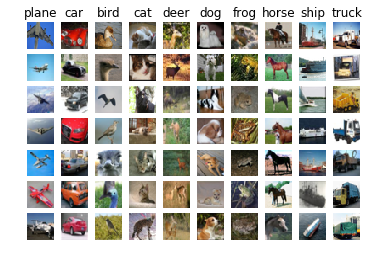

Train data shape:(3073, 9794),
Train labels shape:(9794,), 
Validation data shape:(3073, 206),
Validation labels shape:(206,),
Test data shape:(3073, 2000),
Test labels shape:(2000,),


In [2]:
from algorithms.data_utils import load_CIFAR10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_CIFAR10_data(num_training=49000, num_val=1000, num_test=10000, show_sample=True):
    """
    Load the CIFAR-10 dataset, and divide the sample into training set, validation set and test set
    """

    cifar10_dir = 'cifar-10-batches-py/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # subsample the data for validation set
    mask = range(num_training, num_training + num_val)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    return X_train, y_train, X_val, y_val, X_test, y_test

def subset_classes_data(classes):
    # Subset 'plane' and 'car' classes to perform logistic regression
    idxs = np.logical_or(y_train_raw == 0, y_train_raw == 1)
    X_train = X_train_raw[idxs, :]
    y_train = y_train_raw[idxs]
    # validation set
    idxs = np.logical_or(y_val_raw == 0, y_val_raw == 1)
    X_val = X_val_raw[idxs, :]
    y_val = y_val_raw[idxs]
    # test set
    idxs = np.logical_or(y_test_raw == 0, y_test_raw == 1)
    X_test = X_test_raw[idxs, :]
    y_test = y_test_raw[idxs]
    return X_train, y_train, X_val, y_val, X_test, y_test

def visualize_sample(X_train, y_train, classes, samples_per_class=7):
    """visualize some samples in the training datasets """
    num_classes = len(classes)
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y) # get all the indexes of cls
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs): # plot the image one by one
            plt_idx = i * num_classes + y + 1 # i*num_classes and y+1 determine the row and column respectively
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
    
def preprocessing_CIFAR10_data(X_train, y_train, X_val, y_val, X_test, y_test):
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1)) # [49000, 3072]
    X_val = np.reshape(X_val, (X_val.shape[0], -1)) # [1000, 3072]
    X_test = np.reshape(X_test, (X_test.shape[0], -1)) # [10000, 3072]
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    # Add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T
    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above functions to get our data
X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = get_CIFAR10_data()
visualize_sample(X_train_raw, y_train_raw, classes)
subset_classes = ['plane', 'cat']
X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = subset_classes_data(subset_classes)
X_train, y_train, X_val, y_val, X_test, y_test = preprocessing_CIFAR10_data(X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw)

# As a sanity check, we print out th size of the training and test data dimenstion
print ("Train data shape:{},".format(X_train.shape))
print ("Train labels shape:{}, ".format(y_train.shape))
print ("Validation data shape:{},".format(X_val.shape))
print ("Validation labels shape:{},".format(y_val.shape))
print ("Test data shape:{},".format(X_test.shape))
print ("Test labels shape:{},".format(y_test.shape))

In [3]:
y_train

array([1, 1, 0, ..., 0, 0, 1])

# Logistic Regression Classifier

In [4]:
from algorithms.classifiers.loss_grad_logistic import loss_grad_logistic_naive, loss_grad_logistic_vectorized
from algorithms.classifiers.linear_classifier import LinearClassifier,Logistic
import time
# using BGD algorithm
logistic = Logistic()
tic = time.time()
losses,weight = logistic.train(X_train, y_train, method='sgd', batch_size=200, learning_rate=1e-6,
              reg = 0, num_iters=1000, verbose=True, vectorized=True)
toc = time.time()
print("Traning time for BGD with vectorized version is {}".format(toc - tic))
losses[-1]

iteration 0/1000: loss 1.530281
iteration 100/1000: loss 0.685193
iteration 200/1000: loss 0.454550
iteration 300/1000: loss 0.488554
iteration 400/1000: loss 0.450745
iteration 500/1000: loss 0.443172
iteration 600/1000: loss 0.437898
iteration 700/1000: loss 0.536792
iteration 800/1000: loss 0.452577
iteration 900/1000: loss 0.525145
Traning time for BGD with vectorized version is 1.1125211715698242


0.47463328676559813

/Users/xueying/anaconda3/lib/python3.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


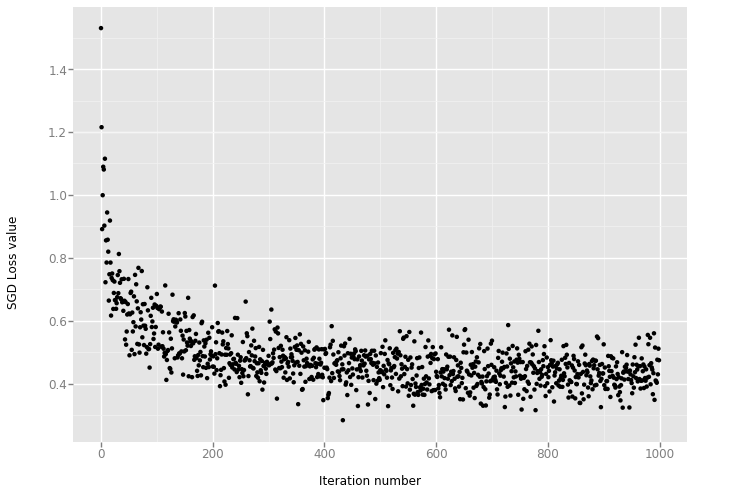

<ggplot: (-9223372033866326356)>

In [5]:
from ggplot import *
qplot(range(len(losses)), losses) + labs(x='Iteration number', y='SGD Loss value')

# Experiments - Convergence

In [8]:
def data_replication(X,y,r):
    if r==1:
        return X,y
    idx = np.random.choice(X.shape[1], int(X.shape[1]/r),replace=False)
    X = np.tile(X[:,idx], r)
    y =np.tile(y[idx], r)
    return X,y

In [21]:
np.random.seed(42)
loss_mtx=[]
loss_mtx2=[]
for r in [1,2,4,8]:
    loss=[]
    loss_2=[]
    X_train_r,y_train_r = data_replication(X_train,y_train,r)
    batch_size=16
    print("Batch size={}".format(batch_size))
    print("Data Replication Factor = {}".format(r))
    
    # choose a best learning rate with batch-size=16
#    d=[]
#    for learning_rate in [1e-6,5e-7]:
#        # number of iterations change accordingly to batch sizes, so that total gradient evaluations are the same for 
#        # each run
#        logistic = Logistic()
#        losses,weight = logistic.train(X_train_r, y_train_r, method='sgd', batch_size=batch_size, learning_rate=learning_rate,
#              reg = 0, num_iters=int(2**16/batch_size), verbose=True, vectorized=True)
#        # average loss over iterations
#        d.append([np.average(losses),learning_rate])
        
#    print("d={}".format(d))
#    gamma = min(d)[1]
#    print("learning rate={}".format(gamma))
    #loss.append(min(d)[0])
    for batch_size in [16,256,512,768]:
        X_train_r,y_train_r = data_replication(X_train,y_train,r)
        print("Batch size={}".format(batch_size))
        print("Data Replication Factor = {}".format(r))
        # number of iterations change accordingly to batch sizes, so that total gradient evaluations are the same for 
        # each run
        logistic = Logistic()
        losses,weight = logistic.train(X_train_r, y_train_r, method='sgd', batch_size=batch_size, learning_rate=1e-6,
              reg = 0, num_iters=int(2**16/batch_size), verbose=True, vectorized=True)

        qplot(range(len(losses)), losses) + labs(x='Iteration number', y='SGD Loss value')
        # average loss over iterations
        loss.append(np.average(losses))
        # loss function with averaged weights from iterations
        l, g = loss_grad_logistic_vectorized(np.average(np.array(weight),axis =0), X_train_r, y_train_r, reg = 0)
        loss_2.append(l)
    loss_mtx.append(loss.copy())
    loss_mtx2.append(loss_2.copy())


Batch size=16
Data Replication Factor = 1
Batch size=16
Data Replication Factor = 1
iteration 0/4096: loss 3.210194
iteration 100/4096: loss 0.674864
iteration 200/4096: loss 0.890519
iteration 300/4096: loss 0.435714
iteration 400/4096: loss 0.223280
iteration 500/4096: loss 0.382310
iteration 600/4096: loss 0.569072
iteration 700/4096: loss 0.225711
iteration 800/4096: loss 0.325637
iteration 900/4096: loss 0.342113
iteration 1000/4096: loss 0.232586
iteration 1100/4096: loss 0.146730
iteration 1200/4096: loss 0.304946
iteration 1300/4096: loss 0.341413
iteration 1400/4096: loss 0.399747
iteration 1500/4096: loss 0.470753
iteration 1600/4096: loss 0.572499
iteration 1700/4096: loss 0.535120
iteration 1800/4096: loss 0.188551
iteration 1900/4096: loss 0.592698
iteration 2000/4096: loss 0.333806
iteration 2100/4096: loss 0.760298
iteration 2200/4096: loss 0.712560
iteration 2300/4096: loss 0.371522
iteration 2400/4096: loss 0.751944
iteration 2500/4096: loss 0.334524
iteration 2600/409

In [22]:
loss_rate=np.array(loss_mtx).T/(np.array(loss_mtx).T[0])
loss_rate

array([[1.        , 1.        , 1.        , 1.        ],
       [1.26420795, 1.34046885, 1.5040833 , 1.77934959],
       [1.36976945, 1.52306649, 1.59733998, 2.08725368],
       [1.4215331 , 1.64554366, 1.76395365, 2.16103748]])

In [23]:
loss_rate2=np.array(loss_mtx2)/np.array(loss_mtx2[0])
loss_rate2

array([[1.        , 1.        , 1.        , 1.        ],
       [0.9615974 , 1.01355865, 1.03699011, 1.07331736],
       [0.83711787, 0.99863294, 0.99462131, 1.01113679],
       [0.62906   , 0.89571582, 0.96557048, 0.99117805]])

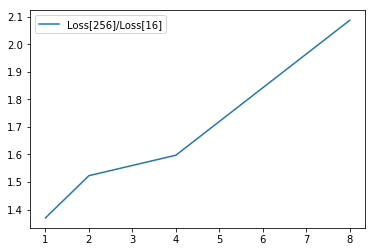

In [30]:
plt.clf()
plt.plot([1,2,4,8],loss_rate[2],label='Loss[256]/Loss[16]')
plt.plot([1,2,4,8],loss_rate[3],label='Loss[512]/Loss[16]')
plt.plot([1,2,4,8],loss_rate[4],label='Loss[768]/Loss[16]')
plt.legend()

In [28]:
a=np.array([[1,2,3,4,5,6],[1,2,3,4,5,6]])
b=np.array([7,8,9,10,11,12])
c,d=data_replication(a,b,3)

In [29]:
c

array([[4, 1, 4, 1, 4, 1],
       [4, 1, 4, 1, 4, 1]])

In [30]:
d

array([10,  7, 10,  7, 10,  7])